In [1]:
%matplotlib widget
from typing import Callable

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Bayesian Inference
Alex Gorodetsky, October 2020
Updated February 2024

In this notebook we will gain intuition about the process of Bayesian inference and how the prior changes into the posterior. We will be "solving" Bayesian inference by analytically evaluating Bayes rule --- this is almost never possible, but we can do it for the simplified situation here. In future lectures we will look at many algorithms to solve Bayes rule.

Considering characterizing the "fairness" of a coin based on observations of its tosses. This problem can be modeled with a single parameter $\theta$ that has the following characteristics. If $\theta = 0$ then we claim that both sides of a coin is tails. If $\theta = 1$ then we claim both sides of the coin are heads. A coin with $\theta = 0.5$ is considered to be a "fair coin." Now we come up with a statistical inference problem:

\begin{align*}
\theta &\in [0, 1] \\
P(H\ |\ \theta) &= \theta \\ 
P(T\ |\ \theta) &= 1-\theta \\
\end{align*}

In [3]:
class Coin:
    """A bernoulli model of a coin."""

    def sample_output(self, param: float, num_samples: int):
        out = scipy.stats.bernoulli.rvs(param, size=num_samples) * 2 - 1
        return out

    def map_output_to_meaning(self, output) -> np.ndarray:
        """Convert numbered output to some meaning."""
        out = np.empty(output.shape[0], dtype=str)
        out[output == 1] = 'H'
        out[output == -1] = 'T'
        return out

    def likelihood_single(self, outputs, param):
        """Likelihood of each single output."""
        likelihoods = np.zeros((outputs.shape))
        likelihoods[outputs == 1] = param
        likelihoods[outputs == -1] = 1-param
        return likelihoods

    def likelihood(self, outputs, param):
        """Likelihood of the data set, assume each output is independnet"""
        return np.prod(self.likelihood_single(outputs, param))

## Data

In this case, the data will consist of $n$ *independent* tosses of the coin
1. HTHTHTTTTHHTHTHT 
2. HTHTH 
3. HHHTTTT  

Let us simulate this scenario

In [4]:
coin = Coin()
out = coin.sample_output(0.5, 5)
coin_tosses = coin.map_output_to_meaning(out)
like = coin.likelihood(out, 0.5)
print("coin tosses = ", coin_tosses)
print("Likelihood of each toss = ", coin.likelihood_single(out, 0.5))
print("Likelihood of dataset = ", like)

coin tosses =  ['T' 'T' 'H' 'T' 'H']
Likelihood of each toss =  [0.5 0.5 0.5 0.5 0.5]
Likelihood of dataset =  0.03125


Now we write a function to generate some "truth" data

In [5]:
def gen_data(num_data: int, truth: float = 0.2):
    """Generate Truth Data."""
    np.random.seed(231)
    true_coin = Coin()
    data = true_coin.sample_output(truth, num_data)
    return data

Now we visualize and store the data

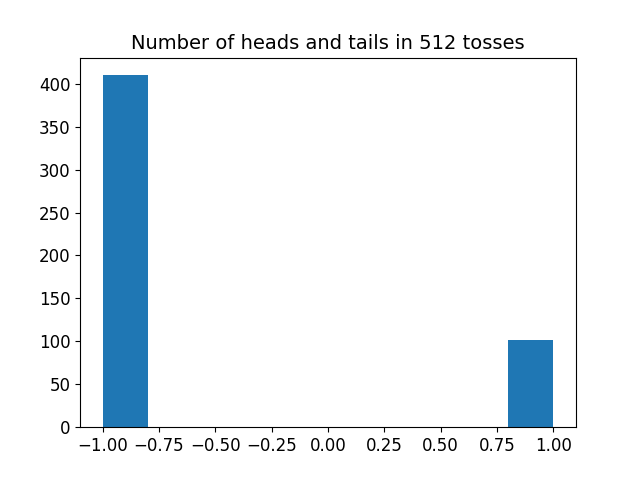

In [6]:
num_data_all = 512
data_all = gen_data(num_data_all)
plt.figure(1)
plt.hist(data_all)
plt.title("Number of heads and tails in 512 tosses", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Prior

Now that we have a model, we need to decide what information we have about the thing we want to learn. 

1) In our case, at the very least, we know that the parameter we want to learn is between 0 and 1, since it is a probability.
2) We also believe that it can be *any* number between 0 and 1
3) Perhaps, we also expect the parameter to be 0.5 because we have no reason to believe it is biased in one way or another. 
4) Perhaps we might also not have any bias towards any particular interval within which the parameter lies.
5) Or perhaps we might have reason to believe that the coin is biased, one way or another.

Once you have identified all the information about the parameter that you want to learn, you must represent this information as a probability distribution that captures this information. There are many ways to converge information to probability distributions, and this is largely the realm of *information theory*. We don't really cover this in great detail in this class. You may want to look up keywords associated with *noninformative priors*, *maximum entropy distributions*, *subjective bayes*, and *objective bayes.* Our task in this class is to develop computation for any specification of the prior. Here we will consider 

1) The uniform distribution
2) The beta distribution
3) The gaussian distribution (this is not technically legal since it has unbounded support, but we will specify it so that the values outside [0,1] are exceedingly small). Mainly, we will use this to make a particular point on prior v.s. likelihood.


In [7]:
def uniform_prior(params: np.ndarray) -> np.ndarray:
    out = np.zeros(params.shape[0])

    inds = np.where((params > 0.0) & (params < 1.0))
    # inds = np.where(((params > .1) & (params < 0.3)) | ((params > 0.7) & (params < 0.8)))
    # inds = np.where(params > 0.5)
    out[inds] = 1.0
    return out

def beta_prior(params: np.ndarray, alpha: float = 0.5, beta: float = 0.5) -> np.ndarray:
    out = np.zeros((params.shape[0]))
    inds = np.where((params > 0) & (params < 1))
    out[inds] = params[inds] ** (alpha - 1.0) * (1.0 - params[inds]) ** (beta - 1.0)
    return out

def gaussian_prior(params: np.ndarray, sigma: float = 0.05) ->np.ndarray:
    return np.exp(-0.5 * (params - 0.5) ** 2 / sigma / sigma)

## Posterior computation

We have now completed the problem setup. We have identified the parameter to learn (the parameter of a Bernoulli random variable that models the probability of flipping heads). We have identified the model, which maps the parameter to the data (a sequence of tosses). We have identified a prior distribution that encapsulates what we know about the parameter prior to learning from the data. Our next task is to perform Bayesian inference, which involves computing the posterior.

But what does it mean to "compute the posterior"? This could mean many things:
1) Get a closed form expression for the pdf/pmf
2) Generate samples from the posterior
3) Have some other representation of the posterior

In this notebook, we will "solve" the Bayesian inference problem by computing an expression for the posterior PDF. Sampels from such a PDF can then be generated by various sampling methods we discussed and will discuss.

In [8]:
def compute_normalizing_constant(data: np.ndarray,
                                 model: Coin,
                                 prior: Callable[[np.ndarray], np.ndarray],
                                 param_vals: np.ndarray):
    """Compute normalizing constant
         -
        /
        |  P(data | \theta) P(\theta) d \theta.
       _/

    Args:
        Model: model defining the sampling distribution
        data: the observed data
        prior: a function returning the pdf for the prior
        param_vals: a set of inputs at which to discretize the above integral

    Notes:

        Uses trapezoid rule on a fine discretization of theta
    """

    prior_vals = prior(param_vals)
    like_vals = np.array([model.likelihood(data, p) for p in param_vals])

    unnormalized_posterior = prior_vals * like_vals

    # Compute the integral using trapezoid rule
    constant = np.trapz(unnormalized_posterior, param_vals)
    return constant, unnormalized_posterior

def compute_posterior(data: np.ndarray,
                      model: Coin,
                      prior: Callable[[np.ndarray], np.ndarray],
                      dx: float = 0.001):
    r"""Compute the posterior over a range of parameters \theta \in [0,1] obtained by discretization of dx"""
    param = np.arange(0, 1 + dx, dx)
    Z, unnormalized_posterior = compute_normalizing_constant(data, model, prior, param)
    return param, unnormalized_posterior / Z


### Some results with a uniform prior

We begin our exploration by seeing what happens with a uniform prior

In [9]:
# fontdict={'fontsize':36}
N = [0, 1, 2, 3, 4, 8, 16, 32, 64, 128, 256, 512]
print(' '.join(coin.map_output_to_meaning(data_all[:num_data_all])))
nrows = 4
ncols = 3
dx = 0.001

T T T T H H T H T T T T T T T T T T H T T T H H T T T T H T H T H T H T T T T T H T T T H T T T T T T T T H T T T T T T T H H T H T T H T T T T T T T H H T H T T T T T H H T T T T T T T T T H T T T T T H T T T H T T T T T T H T T H T T T T T T T T T T T H T T H H T T T T T T T T T H T T H T T T T T H T T T H T T T T T T T T T T T H T H H T T T T T T T T T T T T T H T T T T T T T T T T T H T H T T T T T T H T T H T T T H T T H T T T T H H T T T T T T T T T H T T H T T T T T T T T T T H T T H T T T T T T T H T T T T T H T T H T T T H T T H T T T T T H H T T H T T T T T T T T T T T T T T T T T T T H H T T T H H T H T H T H H T T T T T T T T T T T H T T T T H T T T T T T T T T T T T T T T T T T T T H T T T T H T T H T T T H T T T T T T T T T T T T T T T T T H T T T H T T T T T T T T T T H T T T T T H T H T T T H T T T T T T T T T T H H T T H T T H T T T T T T T T T T T T T T H T T H T T T T T T H T T T H T T H T T T T T H H H T T T H T T H T H H H T H T T T T T T T T T T T T H H T T T T T 

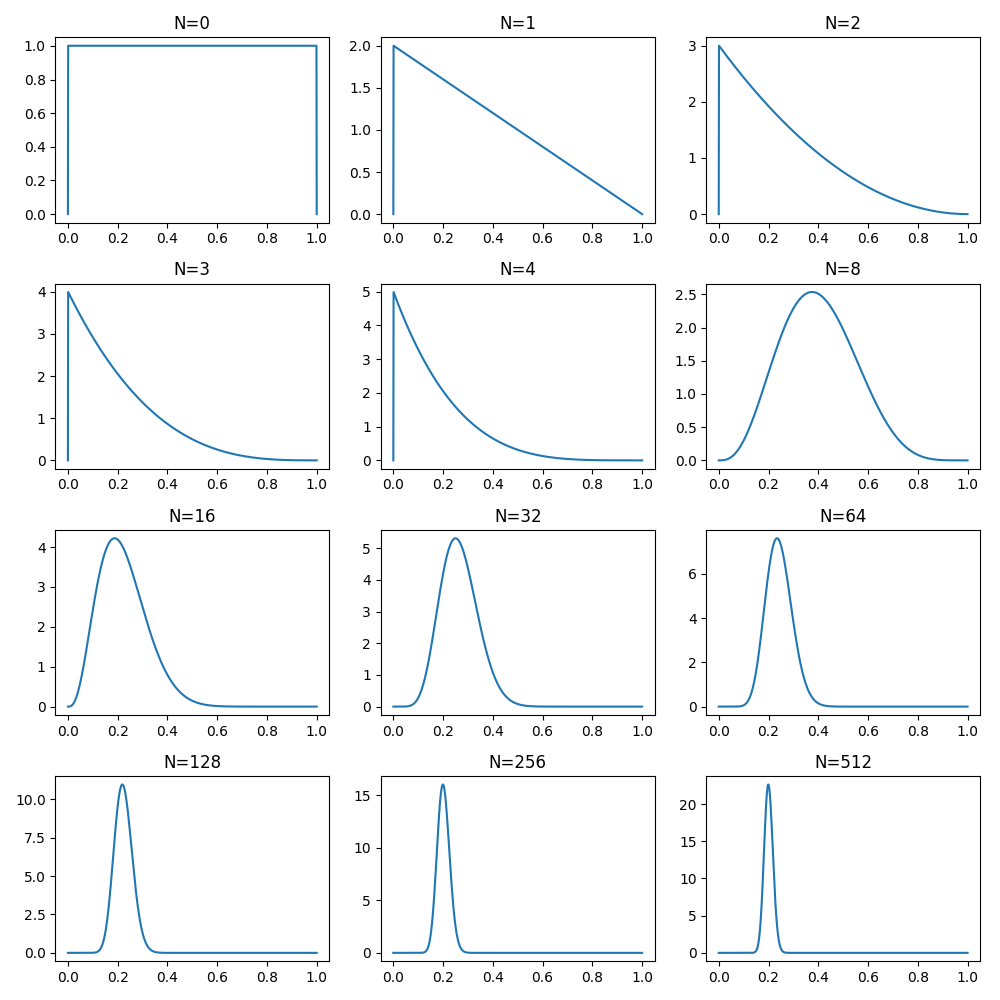

In [10]:
plt.close(2)
fig, axs = plt.subplots(nrows, ncols, num=2, figsize=(10, 10))
for row in range(nrows):
    for col in range(ncols):
        Nuse = N[row * ncols + col]
        param, post = compute_posterior(data_all[:Nuse], coin, uniform_prior, dx)
        axs[row, col].plot(param, post)
        axs[row, col].set_title("N={:d}".format(Nuse), fontsize=12)
plt.tight_layout()
plt.show()

## I do not trust casinos --- I need a different prior if I play there: Beta Prior

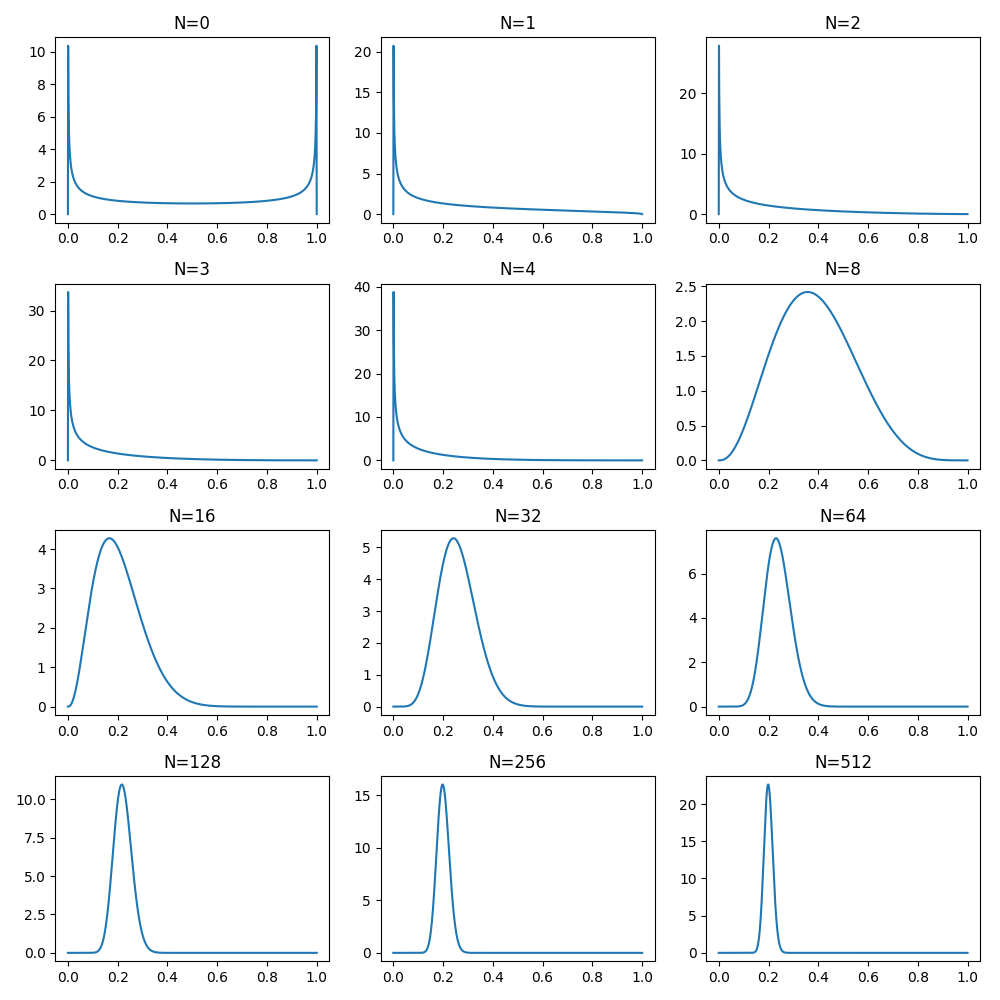

In [11]:
plt.close(3)
fig, axs = plt.subplots(nrows, ncols, num=3, figsize=(10, 10))
for row in range(nrows):
    for col in range(ncols):
        Nuse = N[row * ncols + col]
        param, post = compute_posterior(data_all[:Nuse], coin, beta_prior, dx)
        axs[row, col].plot(param, post)
        axs[row, col].set_title("N={:d}".format(Nuse), fontsize=12)
plt.tight_layout()

## But I do trust my friends (somewhat): Gaussian prior

Gaussian prior (this is an approximation because it has infinite support. Technically, this should be a truncated Gaussian

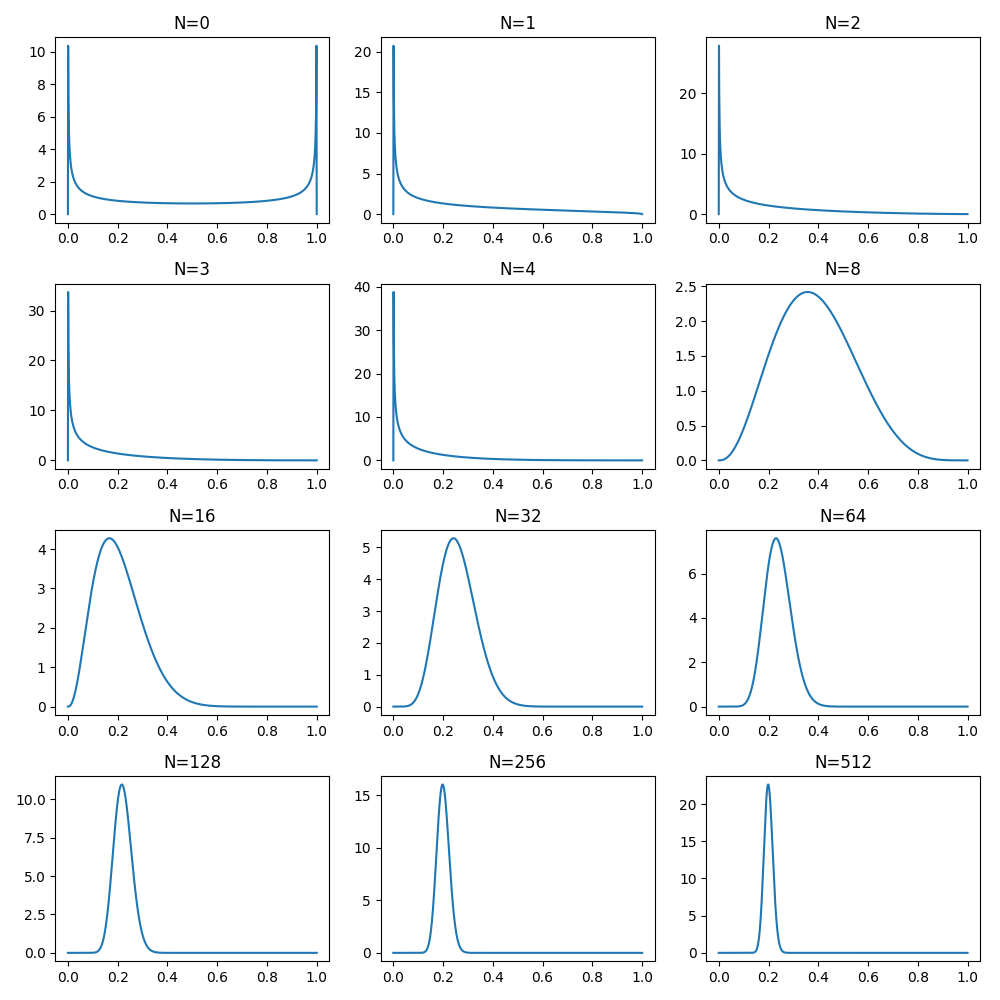

In [12]:
plt.close(4)
fig, axs = plt.subplots(nrows, ncols, num=4, figsize=(10, 10))
for row in range(nrows):
    for col in range(ncols):
        Nuse = N[row * ncols + col]
        param, post = compute_posterior(data_all[:Nuse], coin, beta_prior, dx)
        axs[row, col].plot(param, post)
        axs[row, col].set_title("N={:d}".format(Nuse), fontsize=12)
plt.tight_layout()
plt.show()

## Comparison

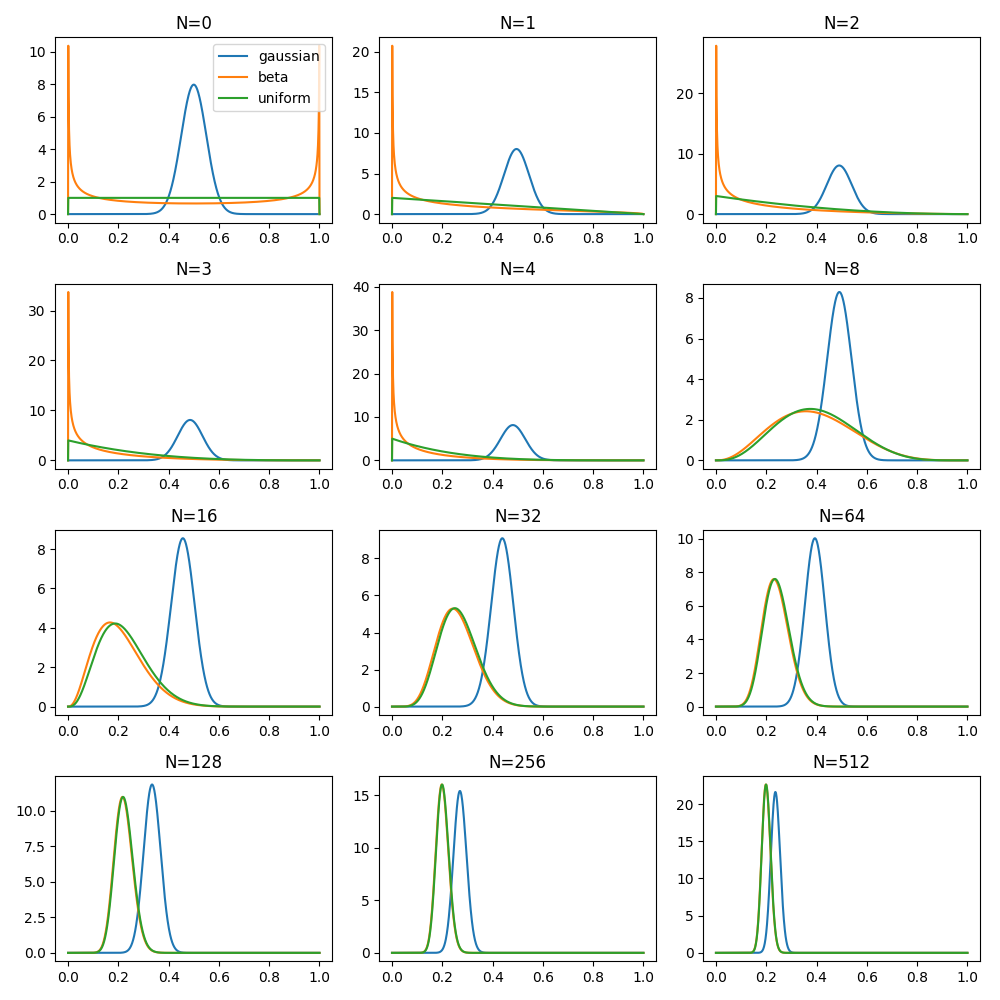

In [13]:
plt.close(5)
fig, axs = plt.subplots(nrows, ncols, num=5, figsize=(10, 10))
for row in range(nrows):
    for col in range(ncols):
        Nuse = N[row * ncols + col]
        param, post = compute_posterior(data_all[:Nuse], coin, gaussian_prior, dx)
        axs[row, col].plot(param, post, label='gaussian')
        param, post = compute_posterior(data_all[:Nuse], coin, beta_prior, dx)
        axs[row, col].plot(param, post, label='beta')
        param, post = compute_posterior(data_all[:Nuse], coin, uniform_prior, dx)
        axs[row, col].plot(param, post, label='uniform')
        axs[row, col].set_title("N={:d}".format(Nuse), fontsize=12)
        if row == 0 and col == 0:
            axs[row, col].legend()
plt.tight_layout()
plt.show()


### An identical viewpoint. 

Suppose now that the problem is slightly different. Instead of seeing a *specific* sequence of heads and tails, someone tells you how many heads there are. 

This is a binomial distribution, and would yield identical results here. Why?

### An explicit look at prior, likelihood, and posterior

Lets visualize the relationship between the prior, likelihood and posterior. Note that for uniform prior the MAP *is* the maximum likelihood estimator as well.

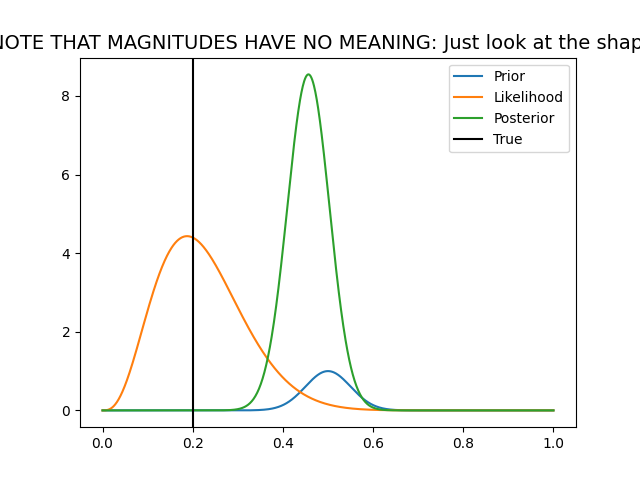

In [14]:
nuse = 16

# prior = uniform_prior
# prior = beta_prior
prior = gaussian_prior

param, post = compute_posterior(data_all[:nuse], coin, prior, dx)
prior_vals = prior(param)
like = np.array([coin.likelihood(data_all[:nuse], p)*1e4 for p in param])  # arbitrary factor multiplied to see

plt.close(6)
plt.figure(6)
plt.plot(param, prior_vals, label='Prior')
plt.plot(param, like, label='Likelihood')
plt.plot(param, post, label='Posterior')
plt.axvline(x=0.2, color='black', label='True')
plt.legend(fontsize=10)
plt.title("NOTE THAT MAGNITUDES HAVE NO MEANING: Just look at the shapes", fontsize=14)
plt.show()


## Comparison to Maximum Likelihood Estimator

As we have been discussing, the frequentist approach will choose to solve this problem via the choice of some estimator. In this case, the maximum likelihood estimator is simply

\begin{equation}
\hat{q} = \frac{\# \text{heads}}{\# \text{number of tosses}}
\end{equation}

Lets add the MLE estimator to the plots we were looking at previously

/var/folders/gw/hg0bj8tj0rzb63d9mz55kzhm0000gn/T/ipykernel_33807/2464790761.py:7: RuntimeWarning: invalid value encountered in divide
  mle = np.sum(data_all[:Nuse] == 1) / float(Nuse)


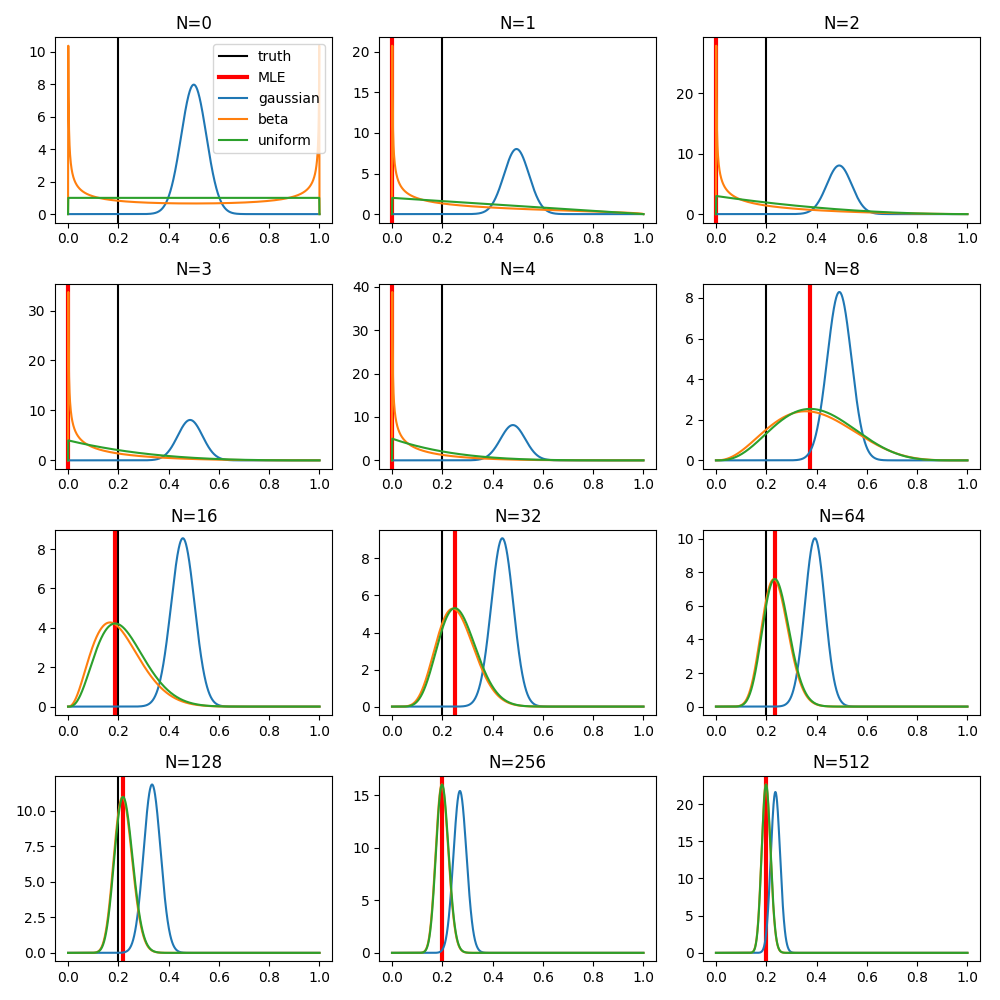

In [17]:
plt.close(7)
fig, axs = plt.subplots(nrows, ncols, num=7, figsize=(10, 10))
for row in range(nrows):
    for col in range(ncols):
        Nuse = N[row * ncols + col]
        axs[row, col].axvline(0.2, color='black', label='truth')
        mle = np.sum(data_all[:Nuse] == 1) / float(Nuse)
        axs[row, col].axvline(mle, color='red', label='MLE', linewidth=3)
        param, post = compute_posterior(data_all[:Nuse], coin, gaussian_prior, dx)
        axs[row, col].plot(param, post, label='gaussian')
        param, post = compute_posterior(data_all[:Nuse], coin, beta_prior, dx)
        axs[row, col].plot(param, post, label='beta')
        param, post = compute_posterior(data_all[:Nuse], coin, uniform_prior, dx)
        axs[row, col].plot(param, post, label='uniform')
        axs[row, col].set_title("N={:d}".format(Nuse), fontsize=12)
        if row == 0 and col == 0:
            axs[row, col].legend()
plt.tight_layout()
plt.show()

# Some Properties (Read on your own)

## Background: Laws of Iterated Expectation and Variance 
Consider a joint distribution of two random variables $X, Y.$ The Law of Iterated Expectation states that

$$\mathbb{E}_{XY}\left[x\right] = \mathbb{E}_{Y}\left[\mathbb{E}_{X\ |\ Y}\left[x\ |y\right]\right] = \mathbb{E}_Y\left[ \phi(y)\right]$$ 

For continuous random variables this is clear from the following equation
$$\mathbb{E}_{XY}\left[x \right] = \int \int x f_{XY}(x, y) dx dy = \int \left[\int x f_{X|Y=y}(x\ |\ y)dx\right] f_{Y}(y) dy$$

There is also the Law of Iterated Variance that states
$$ \mathbb{V}_{XY}\left[x\right] = \mathbb{E}_Y\left[ \mathbb{V}_X\left[x\ |\  y\right]\right] + \mathbb{V}_X\left[\mathbb{E}_Y\left[y\ |\ x\right]\right]$$

## Posterior is a compromise between the data and the prior

The Law of iterated expectation yields
$$\mathbb{E}_{\Theta Y}\left[\theta \right] = \mathbb{E}_{Y}\left[\mathbb{E}_{\Theta|Y}\left[\theta | y \right] \right]$$
This formula can be interepreted to mean that the prior mean of $\theta$ is the average of all possible posterior means over the distribution of possible data.

The Law of iterated variance yields
$$ \mathbb{V}_{\Theta Y}\left[\theta \right] = \mathbb{E}_{Y}\left[ \mathbb{V}_{\Theta}\left[\theta\ |\  y\right]\right] + \mathbb{V}_{\Theta}\left[\mathbb{E}_{Y|\Theta}\left[y\ |\ \theta \right]\right]$$

In other words, this formula says *the posterior variance is on average smaller than the prior variance.* Furthermore,  it is smaller by an amount that depends on the variation of the expected data over the prior. **The greater the variation, the more potential for reducing uncertainty with regards to $\theta$.**

## It doesn't matter if sequential or one-step analysis is performed 

Let $p$ be a generic PDF, for which it will be clear what the underlying random variable is based on the arguments. Then we can show that order of the sequence doesnt matter
\begin{align}
p(\theta \ |\ \textrm{H}) &\propto p(\textrm{H} \ | \ \theta) p(\theta) \\
p(\theta \ |\ \textrm{HT}) &\propto p(\textrm{HT} \ | \ \theta) p(\theta) = p(\textrm{T} \ | \ \textrm{H}, \theta) p(\textrm{H}\ | \ \theta) p(\theta)\\
&= p(\textrm{T} \ | \  \theta)  p(\textrm{H} \ | \ \theta)  p(\theta) \\
                           &\propto p(\textrm{T} \ | \ \theta)p(\theta \ |\ \textrm{H})
\end{align}

Please fill in the argument!